<a target="_blank" href="https://colab.research.google.com/github/da-python/new-modul-python/blob/main/Lesson3/hometask/SyntheticRubber.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании. Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании. Ваша компания запускает новый продукт - "Синтетический каучук" (СК), который по своим свойствам похож на тот, что уже есть на рынке. Ваши клиенты предпочитают формульный подход к ценообразованию. Вам нужно предложить клиентам формулу расчета цены на СК. В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


* СК производиться из нефти. Один из известных способов производства предполагает, что из 10 баррелей нефти сделают одну тонну СК, а затраты на производство в районе 400 евро.

In [ ]:

# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии) 
customers = {
    'Сonty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Ant':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'99': 0.01, # до 100 тонн 1%
             '299': 0.05, #  до 300 тонн 5%
             '300': 0.1}   # больше 300 тонн 10%


### Что нужно сделать?

1. Определить базовую формулу цены на заводе. То есть как бы выглядела цена на исторических данных. 
* Важно, чтобы цена покрывала расходы на производство и при этом была в рынке, то есть на уровне натурального каучука или с небольшим дисконтом, котировки на который можно взять с сайта http://www3.lgm.gov.my/mre/MonthlyPrices.aspx (в центах за килограм). Можно перевести в доллары за тонну.
2. Отобразить на графике.
3. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
4. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента… 



In [ ]:
# !pip install yfinance
# !pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 6.4 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import requests
from tqdm.auto import tqdm
from datetime import date
import time
import matplotlib.pyplot as plt
import os 
import xlsxwriter

In [ ]:
# соберем данные по стоимости нефти
crude_oil_ticker = "CL=F"
crude_oil = yf.Ticker(crude_oil_ticker)
df_oil_price = yf.download(crude_oil_ticker)
df_oil_price = df_oil_price.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
df_oil_price = df_oil_price.rename(columns={'Adj Close':'price_oil'})

[*********************100%***********************]  1 of 1 completed


In [ ]:
# соберем данные по курсу евро к доллару
eurusd_ticker = "EURUSD=X"
eurusd = yf.Ticker(eurusd_ticker)
df_eurusd = yf.download(eurusd_ticker)
df_eurusd = df_eurusd.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
df_eurusd = df_eurusd.rename(columns={'Adj Close':'eurusd'})

[*********************100%***********************]  1 of 1 completed


In [ ]:
# соберем данные по каучуку за прошлый и текущий год
current_year = date.today()
all_kot = []
# year = '2023'
for w in tqdm(range(2022, current_year.year+1)):
#for j in range(12, 0, -1):
  for j in tqdm(range(1, 13)):
    url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={j}&year={w}"
    res = requests.get(url)
    rj = res.json()
    for i in rj:
      if i['grade'] == 'SMR CV':
        dict_one = {'Date': i['date'], 'price': float(i['us']) * 10}
        all_kot.append(dict_one)
  time.sleep(5)

df_price_SMR_SV = pd.DataFrame(all_kot)
df_price_SMR_SV.Date = pd.to_datetime(df_price_SMR_SV.Date)
df_price_SMR_SV = df_price_SMR_SV.rename(columns={'price':'price_SMR_CV'})
df_price_SMR_SV = df_price_SMR_SV.sort_values('Date')
df_price_SMR_SV = df_price_SMR_SV.set_index('Date')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
# объединим все три предыдущих датфрейма в один
data2 = pd.merge(df_oil_price, df_eurusd, how='inner', left_index=True, right_index=True)
data3 = pd.merge(data2, df_price_SMR_SV, how='inner', left_index=True, right_index=True)

In [ ]:
# добавим в датафрейм столбец production_costs, в котором проведем расчет себестоимости производства одной тонны нашего синтетического каучука (в долларах за тонну)
data3 = data3.eval("production_costs = 10 * price_oil + 400 * eurusd")

In [ ]:
# добавим в датафрейм столбец price_SR, в котором проведем расчет оптимальной для нас цены одной тонны синтетического каучука (85 % от цены каучука марки SMR_CV) (в долларах за тонну)
data3 = data3.eval("price_SR = price_SMR_CV * 0.85")

In [ ]:
# 1.1 Определить базовую формулу цены на заводе. То есть как бы выглядела цена на исторических данных.
data3

,price_oil,eurusd,price_SMR_CV,production_costs,price_SR
Date,,,,,
2022-01-03,76.080002,1.137346,2183.5,1215.738382,1855.975
2022-01-04,76.989998,1.130224,2231.5,1221.989765,1896.775
2022-01-05,77.849998,1.128363,2282.0,1229.844999,1939.700
2022-01-06,79.459999,1.131350,2305.5,1247.139864,1959.675
2022-01-07,78.900002,1.129688,2346.0,1240.875273,1994.100
...,...,...,...,...,...
2023-03-30,74.370003,1.084363,1998.5,1177.445412,1698.725
2023-03-31,75.669998,1.090465,1994.5,1192.885962,1695.325
2023-04-03,80.419998,1.080334,1992.5,1236.333418,1693.625


<Axes: xlabel='Date'>

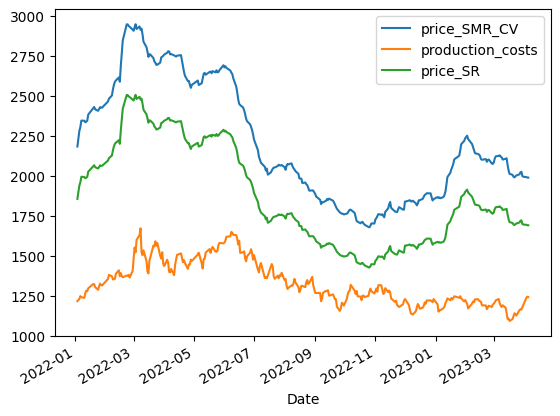

In [ ]:
# 1.2. Отобразить на графике.
# представим данные по ценам и затратам на графике
data4 = data3.drop(['price_oil', 'eurusd'], axis=1)
data4.plot()

In [ ]:
# 1.3. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.

In [ ]:
# посчитаем по всем столбцам средние значения по месяцам
data5 = data3.resample('M').mean()

In [ ]:
data5

,price_oil,eurusd,price_SMR_CV,production_costs,price_SR
Date,,,,,
2022-01-31,82.555556,1.132594,2359.888889,1278.592966,2005.905556
2022-02-28,92.028823,1.135166,2702.205882,1374.354784,2296.875000
2022-03-31,108.262174,1.102412,2806.630435,1523.586738,2385.635870
2022-04-30,101.592105,1.083019,2695.263158,1449.128563,2290.973684
2022-05-31,109.697646,1.058266,2637.029412,1520.283011,2241.475000
2022-06-30,113.947143,1.056958,2483.190476,1562.254773,2110.711905
2022-07-31,99.136842,1.018404,2071.842105,1398.730186,1761.065789
2022-08-31,91.570454,1.013267,1998.795455,1321.011278,1698.976136
2022-09-30,83.736500,0.990794,1821.675000,1233.682690,1548.423750


In [ ]:
def check_volume_discounts(x):
  if 0 < x <= 99:
    return 0.01
  elif 99 < x <= 299:
    return 0.05
  elif x >= 300:
    return 0.1

In [ ]:
print(f" 50 {check_volume_discounts(50)}")
print(f" 150 {check_volume_discounts(150)}")
print(f" 350 {check_volume_discounts(350)}")

 50 0.01
 150 0.05
 350 0.1


In [ ]:
xlfilepath = 'wbp_prices.xlsx'
with pd.ExcelWriter(xlfilepath, engine='xlsxwriter') as writer:
  for client_name, client_info in customers.items():
    client_df = data5.copy()
    
    if client_info.get('location') == 'EU':
      client_df['logistics'] = EU_LOGISTIC_COST_EUR
      client_df['logistics'] = client_df['eurusd'] * EU_LOGISTIC_COST_EUR
    elif client_info.get('location') == 'CN':
      client_df['logistics'] = CN_LOGISTIC_COST_USD
    
    if client_info.get('volumes'):
      client_df['volumes'] = client_info.get('volumes')

    client_df['discount'] = client_df['volumes'].apply(check_volume_discounts)
    client_df['WBP_price_usd'] = client_df['price_SR'] * (1-client_df['discount']) + client_df['logistics']
    
    client_df['WBP_price_usd'].plot(color='red', linestyle="dashed")
    plt.title(f"Client {client_name} WBP Price")
    plt.ylabel("USD")
    plt.tight_layout()
    plt.savefig(f'{client_name}_wbp_price.png')
    plt.close()

    client_df = client_df.round(2)
    client_df = client_df.reset_index()
    client_df.Date = client_df.Date.dt.strftime('%B %Y')
    
    max_row, max_col = client_df.shape
    client_df.to_excel(writer, sheet_name=client_name, startrow=1, header=False, index=False)
    workbook = writer.book
    worksheet = writer.sheets[client_name]
    column_settings = [{'header': column} for column in client_df.columns]
    worksheet.add_table(0, 0, max_row, max_col - 1, {'columns': column_settings})
    worksheet.insert_image(max_row + 3, 1, f'{client_name}_wbp_price.png')

In [ ]:
# 1.4 Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
# Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
# Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf) с именем клиента…

In [ ]:
clients_path = 'for_clients'
os.makedirs(clients_path, exist_ok=True)

In [47]:
# клиенты не должны видеть нашу внутреннюю информацию, поэтому удалим из датафрейма данные, представляющие коммерческую тайну
data_for_clients = data5.drop(['price_oil', 'price_SMR_CV', 'production_costs'], axis=1)

In [48]:
data_for_clients

,eurusd,price_SR
Date,,
2022-01-31,1.132594,2005.905556
2022-02-28,1.135166,2296.875000
2022-03-31,1.102412,2385.635870
2022-04-30,1.083019,2290.973684
2022-05-31,1.058266,2241.475000
2022-06-30,1.056958,2110.711905
2022-07-31,1.018404,1761.065789
2022-08-31,1.013267,1698.976136
2022-09-30,0.990794,1548.423750


In [59]:
for client_name, client_info in customers.items():
  with pd.ExcelWriter(f"for_clients/{client_name}.xlsx", engine='xlsxwriter') as writer: 
    # df.to_excel(writer, sheet_name='Sheet')/
    client_df = data_for_clients.copy()
    
    if client_info.get('location') == 'EU':
      client_df['logistics'] = EU_LOGISTIC_COST_EUR
      client_df['logistics'] = client_df['eurusd'] * EU_LOGISTIC_COST_EUR
    elif client_info.get('location') == 'CN':
      client_df['logistics'] = CN_LOGISTIC_COST_USD
    
    if client_info.get('volumes'):
      client_df['volumes'] = client_info.get('volumes')

    client_df['discount'] = client_df['volumes'].apply(check_volume_discounts)
    client_df['WBP_price_usd'] = client_df['price_SR'] * (1-client_df['discount']) + client_df['logistics']
    
    client_df['WBP_price_usd'].plot(color='red', linestyle="dashed")
    plt.title(f"Client {client_name} WBP Price")
    plt.ylabel("USD")
    plt.tight_layout()
    plt.savefig(f'{client_name}_wbp_price.png')
    plt.close()

    client_df = client_df.round(2)
    client_df = client_df.reset_index()
    client_df.Date = client_df.Date.dt.strftime('%B %Y')
    
    max_row, max_col = client_df.shape
    client_df.to_excel(writer, sheet_name=client_name, startrow=1, header=False, index=False)
    workbook = writer.book
    worksheet = writer.sheets[client_name]
    column_settings = [{'header': column} for column in client_df.columns]
    worksheet.add_table(0, 0, max_row, max_col - 1, {'columns': column_settings})
    worksheet.insert_image(max_row + 3, 1, f'{client_name}_wbp_price.png')




# Задание 2

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

In [92]:
# получаем последнюю актуальную цену на нашу продукцию
price_SR_last = data3.iloc[-1]['price_SR']
# получаем последнюю актуальный курс евро к доллару
eurusd_last = data3.iloc[-1]['eurusd']
current_date = date.today() 
# рассчитываем цену для каждого клиента согласно скидке по объему закупаемой продукции и логистике
for client_name, client_info in customers.items():
  if client_info.get('location') == 'EU':
      client_logistics = EU_LOGISTIC_COST_EUR * eurusd_last
  elif client_info.get('location') == 'CN':
      client_logistics = CN_LOGISTIC_COST_USD 
  price_SR_last_for_client = price_SR_last * (1-check_volume_discounts(client_info.get('volumes'))) + client_logistics
  print(f"Для клиента {client_name} на дату {current_date.day}.{current_date.month}.{current_date.year} цена за 1 тонну составляет ${price_SR_last_for_client.round(2)}")



Для клиента Сonty на дату 5.4.2023 цена за 1 тонну составляет $1638.83
Для клиента Triangle на дату 5.4.2023 цена за 1 тонну составляет $1803.74
Для клиента Stone на дату 5.4.2023 цена за 1 тонну составляет $1638.83
Для клиента Ant на дату 5.4.2023 цена за 1 тонну составляет $1706.46


# Задание 3

К вам пришел новый клиент из России. Который использует продукт А и готов регулярно закупать СК для того, чтобы не быть привязанным к одному поставщику. Клиент готов забирать СК с завода самостоятельно.
На основе тех данных, которые уже есть предложите цену новому клиенту в рублях. 



In [98]:
# USD/RUB (USDRUB=X)
# соберем данные по курсу рубля к доллару
usdrub_ticker = "USDRUB=X"
usdrub = yf.Ticker(usdrub_ticker)
df_usdrub = yf.download(usdrub_ticker)
df_usdrub = df_usdrub.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
df_usdrub = df_usdrub.rename(columns={'Adj Close':'usdrub'})

[*********************100%***********************]  1 of 1 completed


In [99]:
# добавим в датафрейм стобец с курсом рубля к доллару
data_with_rub = pd.merge(data3, df_usdrub, how='inner', left_index=True, right_index=True)

In [100]:
# добавим в датафрейм стобец с ценой за тонну в рублях
data_with_rub = data_with_rub.eval("price_SR_rub = price_SR * usdrub")

In [101]:
data_with_rub

,price_oil,eurusd,price_SMR_CV,production_costs,price_SR,usdrub,price_SR_rub
Date,,,,,,,
2022-01-03,76.080002,1.137346,2183.5,1215.738382,1855.975,74.986000,139172.141463
2022-01-04,76.989998,1.130224,2231.5,1221.989765,1896.775,74.371803,141066.577173
2022-01-05,77.849998,1.128363,2282.0,1229.844999,1939.700,75.263000,145987.642047
2022-01-06,79.459999,1.131350,2305.5,1247.139864,1959.675,76.661598,150231.817463
2022-01-07,78.900002,1.129688,2346.0,1240.875273,1994.100,76.353699,152256.910638
...,...,...,...,...,...,...,...
2023-03-30,74.370003,1.084363,1998.5,1177.445412,1698.725,77.290001,131294.456805
2023-03-31,75.669998,1.090465,1994.5,1192.885962,1695.325,77.239998,130946.899378
2023-04-03,80.419998,1.080334,1992.5,1236.333418,1693.625,77.964996,132043.466923


In [105]:
# рассчитаем актуальную цену для клиента из России в рублях
price_SR_rub_last = data_with_rub.iloc[-1]['price_SR_rub'].round(2)
print(f"Для клиента из России на дату {current_date.day}.{current_date.month}.{current_date.year} цена за 1 тонну составляет {price_SR_rub_last.round(2)} RUB")

Для клиента из России на дату 5.4.2023 цена за 1 тонну составляет 135547.87 RUB
